<p style="text-align:center">
    <a href="https://www.ict.mahidol.ac.th/en/" target="_blank">
    <img src="https://www3.ict.mahidol.ac.th/ICTSurveysV2/Content/image/MUICT2.png" width="400" alt="Faculty of ICT">
    </a>
</p>

# Lab10: Introduction to Time Series Modeling - Assignment

Time Series modeling is an supervised learning technique for forecasting (generating a future outcome) by using historical data. We will use these techniques for:
- `Part 1 - Univariate Forecasting Modeling ("Local Modeling")` of a single time series.
- `Part 2 - Global Forecasting Modeling` of independent multi-series forecasting.

The main focus for this Lab Assignment is on:
- Getting to know `Statistical approaches` to time series modeling (which often work best on `small datasets`).
- Getting to know `neural network approaches` to forecasting (where `large datasets` are required for good results).
- Read through the `Tutorial Notebook` before starting these exercises and questions.


__Instructions:__
1. Append your ID at the end of this jupyter file name. For example, ```ITCS227_Lab0X_Assignment_6788123.ipynb```
2. Complete each task and question in the lab.
3. Once finished, raise your hand to call a TA.
4. The TA will check your work and give you an appropriate score.
5. Submit your IPYNB source code to MyCourses as record-keeping.

```




```
## Prerequisite Check Existing Installation: (takes 20 minutes!)
- For this work, we will use the `Darts` time series forecasting library that depends on `PyTorch` (a large [~2.5GB] and very useful modeling library for DNN/CNN). First we check if it's already installed, and then perform the *basic-CPU* install.
```python
import torch
x = torch.rand(5, 3)
print(x)
```

- `If this fails`:   (takes 20 minutes!)
    ```
    !pip install torch torchvision torchaudio darts
    ```
- `If it succeeded`, then you already have PyTorch installed, therefore install Darts:  (takes ~2 minutes!)
    ```
    !pip install darts

In [1]:
# !pip install torch timport torch
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.2508, 0.1839, 0.7860],
        [0.9582, 0.2464, 0.3108],
        [0.9541, 0.2933, 0.7918],
        [0.3928, 0.1548, 0.0640],
        [0.3858, 0.9312, 0.2051]])


```









```
## Load Imports and Library of Helper Functions

- Run this cell to use its functions later.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.utils.utils import ModelMode

from darts.dataprocessing.transformers import (
    Scaler,
    MissingValuesFiller,
    Mapper,
    InvertibleMapper,
)
from darts.dataprocessing import Pipeline
from darts.metrics import (
    coefficient_of_variation,
    mae,
    mape,
    #marre,
    mase,
    mse,
    rmse,
    ope,
    r2_score
)
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.utils.timeseries_generation import linear_timeseries

from darts.metrics import mape, mae, r2_score, mase


def _display_prediction_evaluations(series, train, val, prediction, sharexy=True):
    # Calculate metrics for component in a multi-series dataset:
    results = {}
    for component in series.components:
        actual = val[component]
        predicted = prediction[component]
        insample = train[component]
        results[component] = {
            "MASE": mase(actual, predicted, insample),
            "MAPE": mape(actual, predicted),
            "MAE": mae(actual, predicted),
            "R2": r2_score(actual, predicted)
        }
    
    # Print the results in a table
    df_results = pd.DataFrame(results).T  # Transpose for better readability
    df_results = df_results.T.rename(columns={i:j for i,j in zip(series.components, columns)}).T
    display(df_results)
    
    # Visualize the results (optional)
    fig, axes = plt.subplots(4, 2, figsize=(12, 8), sharex=sharexy, sharey=sharexy)
    axes = axes.ravel()
    for i, component in enumerate(series.components):
        ax = axes[i]
        train[component].plot(label="Train", color="blue", ax=ax)
        val[component].plot(label="Validation", color="green", ax=ax)
        prediction[component].plot(label="Prediction", color="red", ax=ax)
        ax.set_title(f'{columns[i]} [{component}]')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return df_results


c:\Users\gifly\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


```












```
# 
# Part 1 - Univariate Forecasting Modeling ("Local Modeling") of a single time series. Using Python DARTS Library
## Task 1: Forecasting Cow Milk Production with Feature Engineering with Train/Test Split Evaluation.

### Dataset Load & Prepare:
- Average monthly milk production per cow over 14 years (January 1962 - December 1975).
- References:
    - Makridakis, Wheelwright and Hyndman (1998) Forecasting: methods and applications, John Wiley & Sons: New York. Chapter 2.
    - Cryer (1986) Time series analysis, Duxbury Press: Belmont.
    - Docs: https://unit8co.github.io/darts/generated_api/darts.datasets.html



In [3]:
def _plot_milk(series, forecast, validation, target_column_name):
    known_forecast, uncertain_forecast = forecast[:len(validation)], forecast[len(validation):]
    series.plot(label="actual", lw=1)
    known_forecast.plot(label="measured forecast", color='blue', lw=1)
    if len(uncertain_forecast)>0:
        mape_score = mape(known_forecast, validation)
        uncertain_forecast.plot(label="uncertain forecast", color='red', ls='dashed', lw=0.25)
        d_values = uncertain_forecast.to_dataframe()[target_column_name]
        plt.fill_between(uncertain_forecast.to_dataframe().index, 
                 d_values * (1+(mape_score/100)), 
                 d_values * (1-(mape_score/100)), 
                 color='red', alpha=0.15)
    plt.legend()
    plt.gca().set_ylabel(target_column_name)
    plt.title("MAPE = {:.2f}%".format(mape(known_forecast, validation)))
    metrics = [coefficient_of_variation,
                mae,
                mape,
                #marre,
                #mase,
                mse,
                rmse,
                ope,
                r2_score]
    print(f"Known Forecast Period errors (via validation; n={len(validation)}):")
    _ = [print(f'{m.__name__} = {m(known_forecast, validation)}') for m in metrics]
    
def _plot_box_error(series, prediction_timestamp, pred_value, e_upper, e_lower):
    target_column_name = series.to_dataframe().columns[0]
    dft = series.to_dataframe()
    dft['Year'] = series.to_dataframe().index.year
    ax = dft.boxplot(by='Year')
    ax.set_ylabel(target_column_name)
    years_diff = pd.Timestamp(prediction_timestamp).year - dft.Year.max() 
    yerr = [[abs(pred_value.iloc[0]-e_upper.iloc[0])], [abs(pred_value.iloc[0]-e_lower.iloc[0])]]
    plt.errorbar(len(dft.Year.unique())+years_diff, pred_value, yerr=yerr, fmt='x', color='blue', 
                 ecolor='red', elinewidth=2, capsize=5, capthick=2, label=f'Predicted value\nat {pred_value.iloc[0]:.1f} [{e_upper.iloc[0]:.1f}-{e_lower.iloc[0]:.1f}]\nfor {prediction_timestamp}')
    plt.gca().tick_params(axis='x', rotation=45)
    xticklabels = plt.gca().get_xticklabels() + [plt.Text(i, 0, f'{j}') for i,j in zip(range(len(dft.Year.unique())+1,len(dft.Year.unique())+years_diff+1), 
                                                                                     range(dft.Year.max()+1, pd.Timestamp(prediction_timestamp).year+1))]
    xticks = [t.get_position()[0] for t in xticklabels]
    plt.gca().set_xticks(xticks)
    plt.gca().set_xticklabels(xticklabels)
    _ = plt.legend()
    
def _plot_milk_with_prediction(series, new_forecast, validation, pred_value, prediction_timestamp, target_column_name):
    _plot_milk(series, new_forecast, validation, target_column_name)
    plt.gca().axhline(pred_value.iloc[0], color='g', ls=(0, (5, 10)), lw=0.5)
    plt.gca().axvline(pd.Timestamp(prediction_timestamp), color='g', ls=(0, (5, 10)), lw=0.5)
    plt.scatter(pd.Timestamp(prediction_timestamp), pred_value, s=15, marker='x', color='g', label=f'Predicted value at {prediction_timestamp}\n{pred_value.iloc[0]:.3f}')
    _ = plt.legend()
    
def _collect_filled_dataset(get_dataset):
    series = get_dataset().load()
    filler = MissingValuesFiller()
    series = filler.transform(series, method="quadratic")
    return series

def _get_scale_transformer():
    return Scaler(MinMaxScaler(feature_range=(0, 1))) 

def _collect_scaled_dataset(series):
    transformer = _get_scale_transformer()
    original_series = series.copy()
    series = transformer.fit_transform(series)
    return series, transformer

def collect_preprocessed_dataset(get_dataset):
    series = _collect_filled_dataset(get_dataset)
    series, transformer = _collect_scaled_dataset(series)
    return series, transformer 

def model_fit_predict_rmse( model,  training, validation, transformer, predict_period=36, target_column_name='target' ):
    print(f'Model: {model.__class__.__name__}')
    
    context = SuppressOutput if isinstance(model, LightGBMModel) else NoSpecialAction
    with context():
        model.fit(training)
        forecast = model.predict( predict_period )
    
    series_ori = transformer.inverse_transform(series.copy())
    validation_ori = transformer.inverse_transform(validation.copy())
    forecast_ori = transformer.inverse_transform(forecast.copy())
    
    rmse_score = rmse(forecast_ori, validation_ori)
    # _display_rmse(rmse_score)
    # _plot_milk(series_ori, new_forecast_ori, validation_ori, target_column_name)
    return [{
        'model':model.__class__.__name__,
        'rmse':rmse_score
           }]

import sys

class NullWriter:
    def write(self, *args, **kwargs):
        pass

    def flush(self):
        pass

class NoSpecialAction:
    def __enter__(self):
        pass

    def __exit__(self, exc_type, exc_val, exc_tb):
        pass
        
class SuppressOutput:
    def __enter__(self):
        self.original_stdout = sys.stdout  # Save the original stdout
        sys.stdout = NullWriter()           # Redirect stdout to NullWriter

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout = self.original_stdout   # Restore original stdout

In [4]:

from darts.datasets import AirPassengersDataset, MonthlyMilkIncompleteDataset

get_dataset = MonthlyMilkIncompleteDataset
series = get_dataset().load()

- We're loading a `Time Series dataset`, which is an extension to Pandas DataFrames; however the time "component" (is the index and) is external to the historical data. Both are important.

In [5]:
display(series.to_dataframe() )
series.to_dataframe().describe()

component,Pounds per cow
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0
...,...
1975-08-01,858.0
1975-09-01,NaN
1975-10-01,NaN


component,Pounds per cow
count,155.000000
mean,755.722581
std,103.251335
min,553.000000
25%,677.000000
50%,762.000000
75%,826.000000
max,969.000000


- Plot the series data, and notice there are several missing data periods:

<Axes: xlabel='Month'>

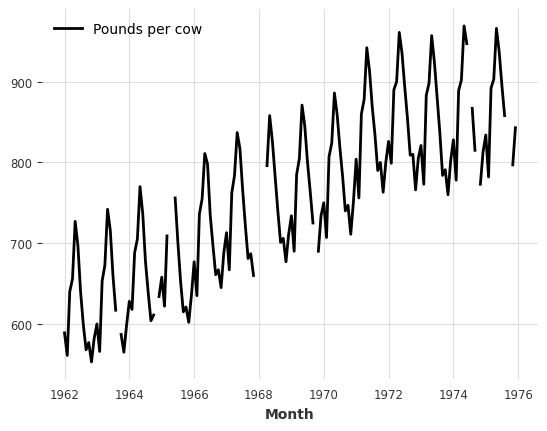

In [6]:
series.plot()

##### Fill in missing values:
- Uses quadratic interpolation

<Axes: xlabel='Month'>

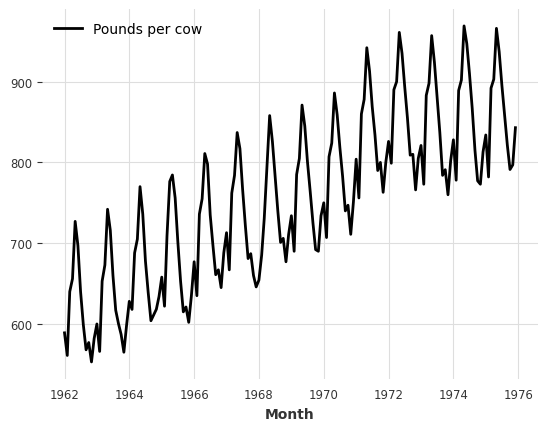

In [7]:
filler = MissingValuesFiller()
series = filler.transform(series, method="quadratic")
series.plot()

##### Normalize the Value Scale

**Note:**
- (-1,1) or StandardizedScaling (mean==0) are standard recommendations for neural network-based and numerical models, which allow both +/- values in a single unit-variance magnitude.
- While (0,1) only controls for magnitudinal range differences.


<Axes: xlabel='Month'>

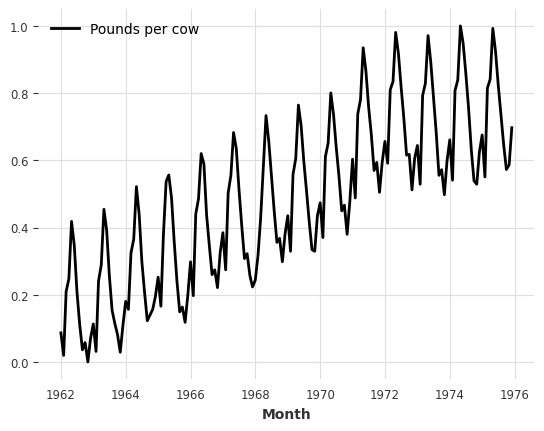

In [8]:
from sklearn.preprocessing import MinMaxScaler
transformer = Scaler(MinMaxScaler(feature_range=(0, 1))) 
original_series = series.copy()
series = transformer.fit_transform(series)
series.plot()

##### Inverse the normalized scale:
- To get our prediction results back the original scale, we must revert the scale; back to the original range.
- We can use `inverse_transform()` for this later; and `predictions_ori = transformer.inverse_transform(predictions)`.

<Axes: xlabel='Month'>

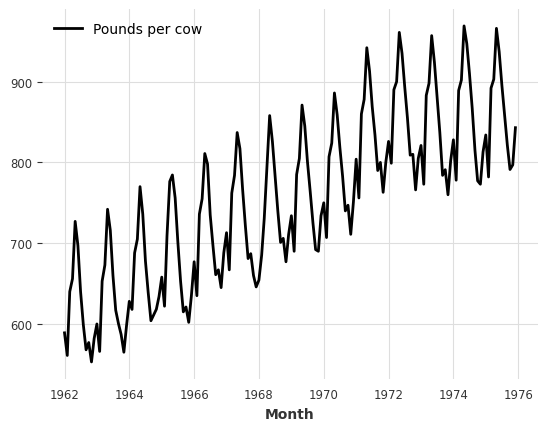

In [9]:
series2 = transformer.inverse_transform(series.copy())
series2.plot()

In [10]:
t = transformer.__dict__['_fitted_params'][0]
t.scale_, t.min_, t.data_min_, t.data_max_, t.data_min_*t.scale_

(array([0.00240385]),
 array([-1.32932692]),
 array([553.]),
 array([969.]),
 array([1.32932692]))

##### Perform Model Training and Forecast Prediction Error (MAPE) for future milk production:
- The `ExponentialSmoothing` algorithm will be used to train the fitted model for prediction. Using a hold-out split of train/validation sets and test sets.
- The `MAPE` error will inform us about the mean average percentage error of the model, in terms of % correctness (in the test period).
- We will look at `RMSE` error also to discover the predicted milk production.

### Fit the Exponential Smoothing Model:
- Plot the Milk Results:

In [11]:
target_column_name = series.to_dataframe().columns[0]
training, validation = series.split_before(pd.Timestamp("1973-01-01"))
predict_period = 36

Known Forecast Period errors (via validation; n=36):
coefficient_of_variation = 12.013373152346293
mae = 0.08851834010425765
mape = 11.310031476684925
mse = 0.009448386891533973
rmse = 0.09720281318734542
ope = 10.940052202493142
r2_score = 0.531444605202513


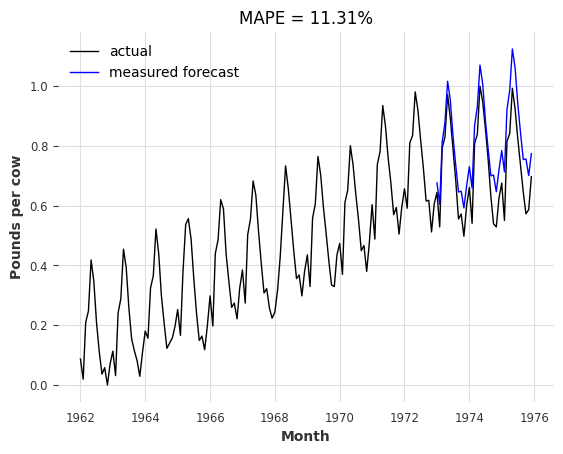

In [12]:
from darts.models import ExponentialSmoothing
from darts.utils.utils import ModelMode, SeasonalityMode

model = ExponentialSmoothing(
    trend=ModelMode.ADDITIVE, 
    seasonal=SeasonalityMode.ADDITIVE
)
model.fit(training)
forecast = model.predict( predict_period )
_plot_milk(series, forecast, validation, target_column_name)

##### Interpreting the RMSE error, in terms of the Pounds of Milk per month:
- To do this, we have to reverse the earlier data scaling (to return the error value into the correct range).
- Essentially, this is $scaling\_factor * predictions$, then perform the $error = RMSE(y_t,y_p)$ error calculation. Then divide the error over the prediction period (36 months), into a single month's error, per cow in pounds.
- We apply `y_pred = transformer.inverse_transform(y_pred)`, then we can re-evaluate `RMSE()` and each of the metrics in the original value range.

##### Inverse Scaling of Predictions:

In [13]:
validation_ori = transformer.inverse_transform(validation.copy())
forecast_ori = transformer.inverse_transform(forecast.copy())
series_ori = transformer.inverse_transform(series.copy())

In [14]:
def _display_rmse(error):
    print(f'The model prediction error (RMSE) of Milk Production per cow per month into the forecasted prediction period is:\n{error:.3f} (pounds per cow per month).')
    kgs = error/2.2
    print(f'{kgs:.3f} (kilograms per cow per month).')

In [15]:
rmse_score = rmse(forecast_ori, validation_ori)
_display_rmse(rmse_score)

rmse_score

The model prediction error (RMSE) of Milk Production per cow per month into the forecasted prediction period is:
40.436 (pounds per cow per month).
18.380 (kilograms per cow per month).


40.4363702859357

Known Forecast Period errors (via validation; n=36):
coefficient_of_variation = 4.545482672971072
mae = 36.82362948337119
mape = 4.161239213227604
mse = 1635.1000419013037
rmse = 40.4363702859357
ope = 4.139371773207544
r2_score = 0.5314446052025131


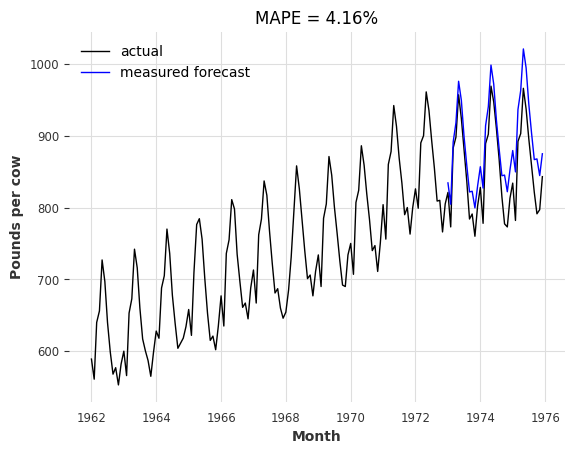

In [16]:
_plot_milk(series_ori, forecast_ori, validation_ori, target_column_name)

##### A Future prediction in an unknown/unseen time period, with expected MAPE error of 4.16%, at 18.380 KG per cow per month.
- Let's look at a predicted forecast into the far future. In theory, the model's MAPE error indicates we can expect $\pm$4.16% error on this forecast estimate.
- The dataset ends in 1976, so lets make a forecast for 1980, `4 years` into the "future".
- We could request  `48=12*4` (monthly) predictions, or request a longer period.
- We must be careful in interpreting the error for this `uncertain forecast` period.

Known Forecast Period errors (via validation; n=36):
coefficient_of_variation = 4.545482672971072
mae = 36.82362948337119
mape = 4.161239213227604
mse = 1635.1000419013037
rmse = 40.4363702859357
ope = 4.139371773207544
r2_score = 0.5314446052025131


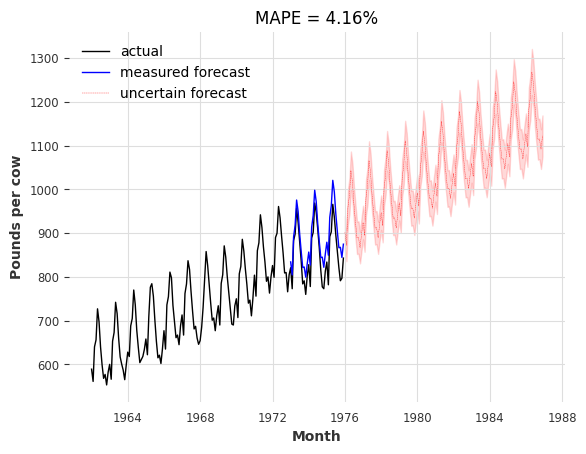

In [17]:
new_forecast = model.predict(n=len(series))
new_forecast_ori = transformer.inverse_transform(new_forecast.copy())

_plot_milk(series_ori, new_forecast_ori, validation_ori, target_column_name)

### Make Individual Forecast Prediction:

#### Make an "uncertain" Forecast Prediction for 1980-09-01 (beyond the dataset):
- Collect to the specific-time prediction:

In [18]:
prediction_timestamp = '1980-09-01'
display(new_forecast.to_dataframe().loc[prediction_timestamp])

component
Pounds per cow    1.024865
Name: 1980-09-01 00:00:00, dtype: float64

In [19]:
pred_value = new_forecast_ori.to_dataframe().loc[prediction_timestamp]
pred_value

component
Pounds per cow    979.343717
Name: 1980-09-01 00:00:00, dtype: float64

##### Plot the prediction value in terms of the forecast, including the MAPE range.

Known Forecast Period errors (via validation; n=36):
coefficient_of_variation = 4.545482672971072
mae = 36.82362948337119
mape = 4.161239213227604
mse = 1635.1000419013037
rmse = 40.4363702859357
ope = 4.139371773207544
r2_score = 0.5314446052025131


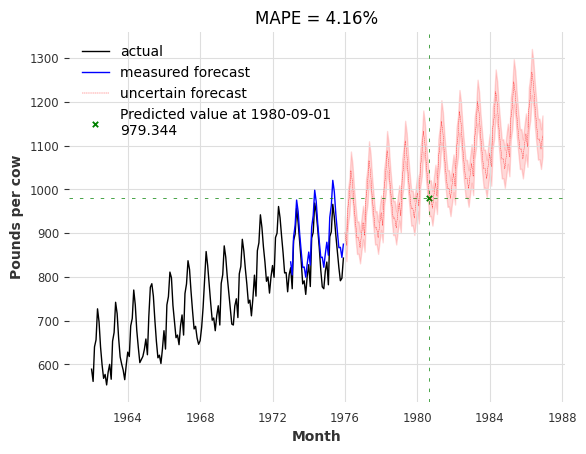

In [20]:
_plot_milk_with_prediction(series_ori, new_forecast_ori, validation_ori, pred_value, prediction_timestamp, target_column_name)

#### Add Error Range to Forecast Prediction:
- Apply the re-scaling factor, and include the MAPE error range:

In [21]:
mape_score = mape(forecast_ori, validation_ori)
pred_value, e_upper, e_lower = pred_value, pred_value * (1-(mape_score/100)), pred_value * (1+(mape_score/100))
pred_value, e_upper, e_lower

(component
 Pounds per cow    979.343717
 Name: 1980-09-01 00:00:00, dtype: float64,
 component
 Pounds per cow    938.590882
 Name: 1980-09-01 00:00:00, dtype: float64,
 component
 Pounds per cow    1020.096552
 Name: 1980-09-01 00:00:00, dtype: float64)

##### BoxPlot visualization by year

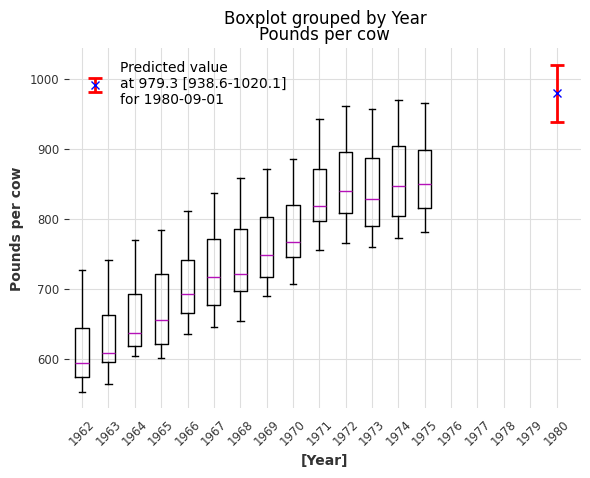

In [22]:
_plot_box_error(series_ori, prediction_timestamp, pred_value, e_upper, e_lower)

```







```
## Task 2: Try another model to compare against ExponentialSmoothing Model.
- Comparing models is very similar approaches as with Sci-Kit Learn. It is possible to measure `time to fit` and `time to prediction`, as well as `metrics of correctness`, as we have done with `RMSE` and `MAPE`.

In [23]:
target_column_name = series.to_dataframe().columns[0]
training, validation = series.split_before(pd.Timestamp("1973-01-01"))
predict_period = 36

### ACTION: Try a new model with the intention to improve MAPE Error:
    - Add a new model (see [Darts Models API](https://unit8co.github.io/darts/#forecasting-models))

In [24]:
# Insert your code here:
from darts.models import LinearRegressionModel
model = LinearRegressionModel(lags=50)

model.fit(training)
forecast = model.predict( predict_period )

<details><summary><span style="color:red">&#x1F6C8; Help</span> (Use this only as a last resort!!)</summary>

- Take a read of: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.linear_regression_model.html
- You should only need the `lags=...` parameter for the model. Try different `lags` values until you get a lower MAPE error than 4.16%.

```python
from darts.models import LinearRegressionModel
# from darts.models import ( ExponentialSmoothing, FFT, AutoARIMA, 
#                          Theta, ARIMA, RegressionModel )
# from darts.utils.utils import ModelMode, SeasonalityMode
# from darts.models import NBEATSModel, XGBModel
# from darts.models.forecasting.lgbm import LightGBMModel
```


</details>


- Once trained and forecast is predicted, plot and note the evaluation metric score(s):

Known Forecast Period errors (via validation; n=36):
coefficient_of_variation = 3.8223927357526772
mae = 26.242994561649475
mape = 2.9778968869032316
mse = 1128.5142747670814
rmse = 33.593366529228376
ope = 2.968173240574949
r2_score = 0.6926045086516754


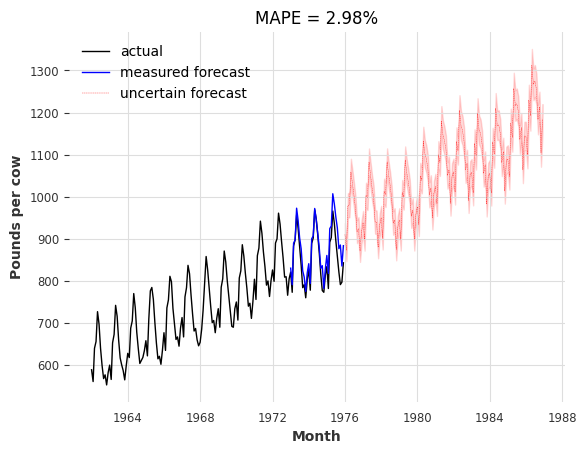

In [25]:
validation_ori = transformer.inverse_transform(validation.copy())
series_ori = transformer.inverse_transform(series.copy())
forecast_ori = transformer.inverse_transform(forecast.copy())
new_forecast = model.predict(n=len(series))
new_forecast_ori = transformer.inverse_transform(new_forecast.copy())

_plot_milk(series_ori, new_forecast_ori, validation_ori, target_column_name)


### Q: Make a note of which `model` and `parameters` you tried and the `MAPE %` score. Is it better than the existing model at 4.16%?
- For MAPE, we are looking for the smallest positive % error (close to zero).

Ans: Linear regression model, lags = 50, MAPS = 2.98

```









```

```






```
## Task 3: Let's add Feature Engineering - Milk produced by cows does not endlessly grow forever.. so let's reduce that in the later years:

**Question: Can we integrate our domain knowledge about cows and milking into the model? Then further test the model.**

Let's add:
- a tapered curve -- i.e. the milk produced by cows does not endlessly grow forever.. so let's reduce that in the later years. Note: we can see that the data-trend is slowing in the later 5 years.

Let's apply a function to taper the curve as time passes:

- By example, we can change the taper a line as below.
    - Note the transform formula:  $x^{0.8}$
    - And the inverse formula:  $x^{1/0.8}$ - which is used to correct it later.

0.8


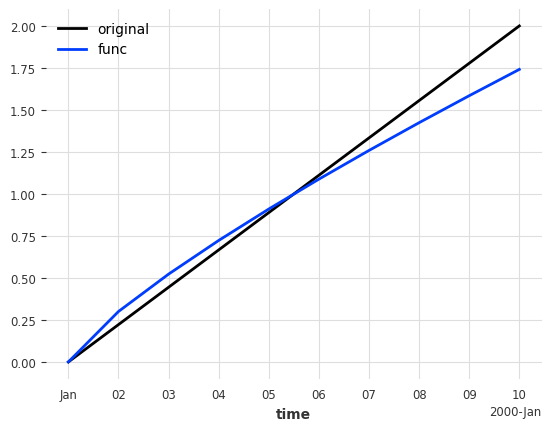

In [26]:
from darts.utils.timeseries_generation import linear_timeseries
from darts.dataprocessing.transformers import Mapper, InvertibleMapper


def _example_plot(_modifier):
    lin_series = linear_timeseries(start_value=0, end_value=2, length=10)
    f = InvertibleMapper(
        fn=lambda x: x**_modifier,
        inverse_fn=lambda x: np.power(y, 1/_modifier),
    )
    func = f.transform(lin_series)
    
    lin_series.plot(label="original")
    func.plot(label="func")
    plt.legend()
    print(_modifier)

_example_plot(_modifier=0.8)

- Note, our transformed data is less than 1.
    - For $x<1$ the exponental function $x^{2}$ has a reducing effect.
    - For $x>1$ the exponental function $x^{2}$ has an increasing effect.

In [27]:
e = 1.5
i0, i1 = 0.9, 1.1
print(f'For example:\n\t[below 1] {i0}^{e} = {i0**e:.4f} \n\t[above 1] {i1}^{e} = {i1**e:.4f}')

For example:
	[below 1] 0.9^1.5 = 0.8538 
	[above 1] 1.1^1.5 = 1.1537


- Check the function inverse works correctly::

In [28]:
import numpy as np
x = 10
y = x **1.2
np.power(y, 1/1.2) == x

True

### Define and Apply the Taper transform function: using `modifier=1.2`

In [29]:
def custom_taper( taper_curve_function, training, split_pos=-36):
    func = taper_curve_function.transform(training[-36:])
    early = training[:-36]
    func = TimeSeries.from_dataframe(pd.concat([early.to_dataframe(), func.to_dataframe()]))
    return func
taper_curve_function = InvertibleMapper(
    fn=lambda x: x**1.2,
    inverse_fn=lambda x: np.power(x, 1/1.2),
)

- Get a fresh set of data, and apply the transform to the end of the training data:
    - This will modify the training data.

In [30]:
get_dataset = MonthlyMilkIncompleteDataset
series, transformer = collect_preprocessed_dataset(get_dataset)

training, validation = series.split_before(pd.Timestamp("1973-01-01"))
new_training = custom_taper( taper_curve_function, training, split_pos=-36)

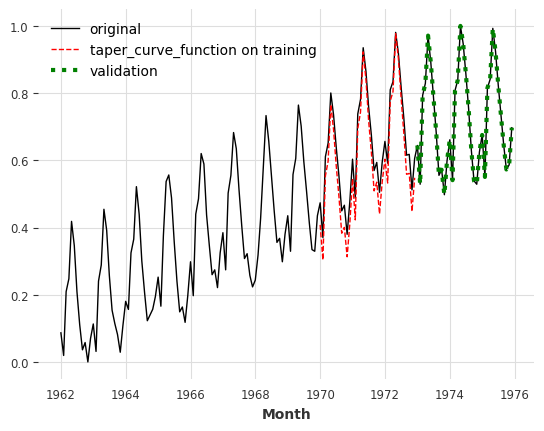

In [31]:
def _plot_tapered_training_data(series, new_training, validation):
    series.plot(label="original", lw=1)
    new_training[-36:].plot(label="taper_curve_function on training", lw=1, color='red', ls='dashed')
    validation.plot(label="validation", lw=3, color='green', ls='dotted')
    plt.legend()
    plt.show()
    
_plot_tapered_training_data(series, new_training, validation)

- Confirm the inverse function works correctly:

RMSE: 0.000000000


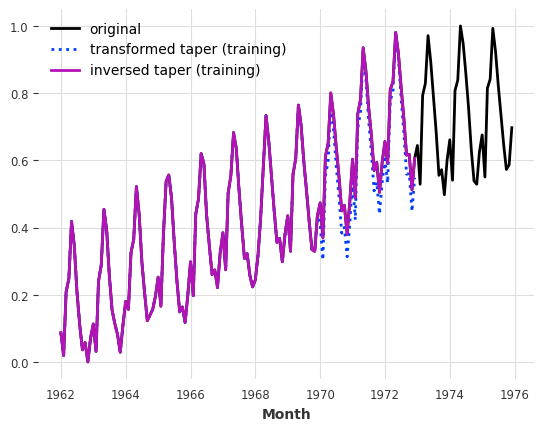

In [32]:
def custom_inverse_taper( taper_curve_function, new_training, validation, split_pos=-36):
    func = taper_curve_function.inverse_transform(new_training[split_pos:])
    early = new_training[:split_pos]
    func = TimeSeries.from_dataframe(pd.concat([early.to_dataframe(), func.to_dataframe()]))
    return func

series.plot(label="original")
new_training.plot(label="transformed taper (training)", ls='dotted')

func = custom_inverse_taper( taper_curve_function, new_training, validation, split_pos=-36)
func.plot(label='inversed taper (training)')
print(f'RMSE: {rmse(func, series):.9f}')

### ACTION: Fit the Model to the new Data and Compare MAPE %:
- Add your best model so far here (either ExponentialSmoothing, or your new variant), to compare its `MAPE %`:

In [33]:
# Insert your code here:
model = LinearRegressionModel(lags=50)

model.fit(new_training)
forecast = model.predict( predict_period )


- Plot and show the model evaluation metrics:

Known Forecast Period errors (via validation; n=36):
coefficient_of_variation = 4.155617973585172
mae = 28.911232031276175
mape = 3.571369514078432
mse = 1188.96930633126
rmse = 34.48143422671482
ope = 2.773873073335005
r2_score = 0.7331882648352311


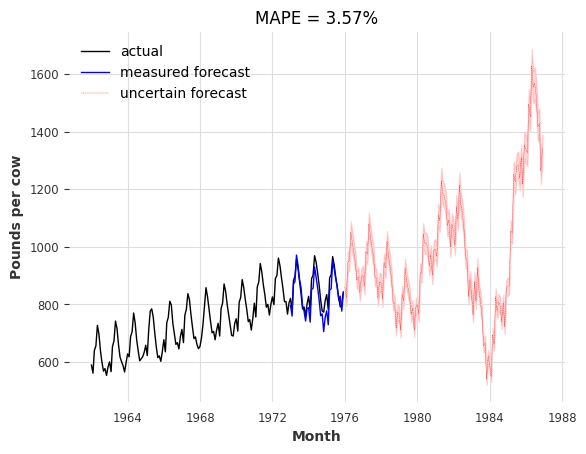

In [34]:
validation_ori = transformer.inverse_transform(validation.copy())
series_ori = transformer.inverse_transform(series.copy())
forecast_ori = transformer.inverse_transform(forecast.copy())
new_forecast = model.predict(n=len(series))
new_forecast_ori = transformer.inverse_transform(new_forecast.copy())

_plot_milk(series_ori, new_forecast_ori, validation_ori, target_column_name)

- Monitor the RMSE Score:

In [35]:
rmse_score = rmse(forecast_ori, validation_ori)
_display_rmse(rmse_score)

rmse_score

The model prediction error (RMSE) of Milk Production per cow per month into the forecasted prediction period is:
34.481 (pounds per cow per month).
15.673 (kilograms per cow per month).


34.48143422671482

### Q: Did the RMSE Score improve with the new training curve? 

- Ans: No

### Q: What is the difference in RMSE Error for `Milk Pounds per Cow per Month` between this trained model and the previous? Better or worse?

- Ans: Worse, it's increase the error by 0.1%

```



```
##### Final steps: show the newly updated future forecast prediction:

Known Forecast Period errors (via validation; n=36):
coefficient_of_variation = 4.155617973585172
mae = 28.911232031276175
mape = 3.571369514078432
mse = 1188.96930633126
rmse = 34.48143422671482
ope = 2.773873073335005
r2_score = 0.7331882648352311


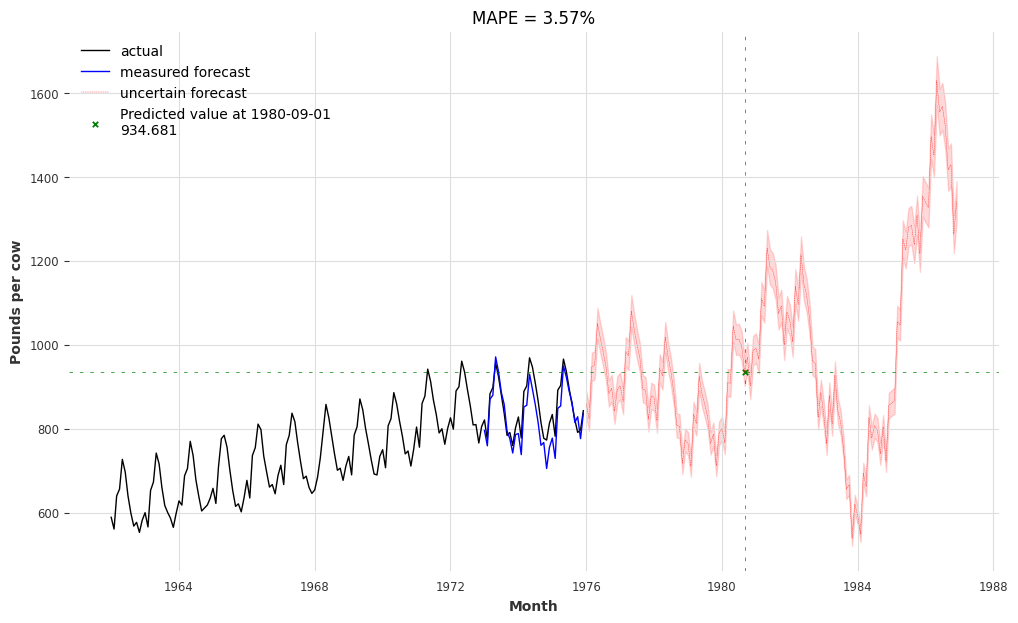

In [36]:
new_forecast = model.predict(n=len(series))
new_forecast_ori = transformer.inverse_transform(new_forecast.copy())
prediction_timestamp = '1980-09-01'
pred_value = new_forecast_ori.to_dataframe().loc[prediction_timestamp]
series_ori = transformer.inverse_transform(series.copy())
validation_ori = transformer.inverse_transform(validation.copy())

_plot_milk_with_prediction(series_ori, new_forecast_ori, validation_ori, pred_value, prediction_timestamp, target_column_name)
plt.gcf().set_size_inches(12, 7)

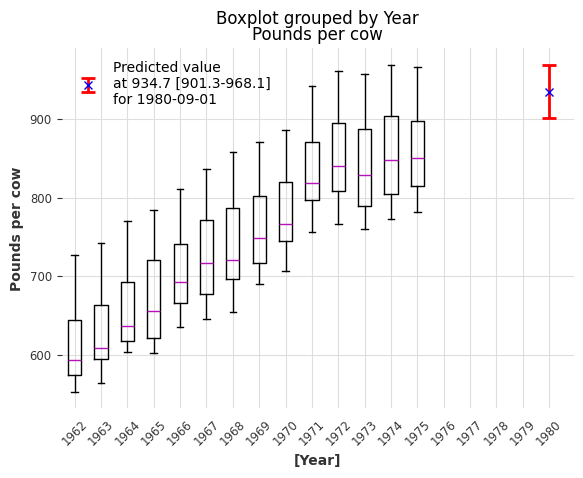

In [37]:
mape_score = mape(new_forecast_ori, validation_ori)
pred_value, e_upper, e_lower = pred_value, pred_value * (1-(mape_score/100)), pred_value * (1+(mape_score/100))
_plot_box_error(series_ori, prediction_timestamp, pred_value, e_upper, e_lower)

```



















```
# 
# Part 2 - Global Forecasting Modeling of independent multi-series forecasting.

Global forecasting, involves building a single predictive model that considers all time series simultaneously. It attempts to capture the core patterns that govern the series, thereby mitigating the potential noise that each series might introduce. This approach is computationally efficient, easy to maintain, and can yield more robust generalizations across time series.


## Task 1:

#### Influenza Like Illness Dataset
ILI describes the number of patients seen with influenzalike illness and the total number of patients. It includes weekly data from the Centers for Disease Control and Prevention of the United States from 1997 to 2022.

##### Components Descriptions:
- % WEIGHTED ILI: Combined state-specific data of patients visit to healthcare providers for ILI reported each week weighted by state population
- % UNWEIGHTED ILI: Combined state-specific data of patients visit to healthcare providers for ILI reported each week unweighted by state population
- AGE 0-4: Number of patients between 0 and 4 years of age
- AGE 25-49: Number of patients between 25 and 49 years of age
- AGE 25-64: Number of patients between 25 and 64 years of age
- AGE 5-24: Number of patients between 5 and 24 years of age
- AGE 50-64: Number of patients between 50 and 64 years of age
- AGE 65: Number of patients above (>=65) 65 years of age
- ILITOTAL: Total number of ILI patients. For this system, ILI is defined as fever (temperature of 100°F [37.8°C] or greater) and a cough and/or a sore throat
- NUM. OF PROVIDERS: Number of outpatient healthcare providers
- TOTAL PATIENTS: Total number of patients

##### References:
1. https://gis.cdc.gov/grasp/fluview/fluportaldashboard.html
2. https://www.cdc.gov/flu/weekly/overview.htm#Outpatient
3. https://arxiv.org/pdf/2205.13504.pdf
4. https://gis.cdc.gov/grasp/fluview/FluViewPhase2QuickReferenceGuide.pdf

In [38]:
from darts.dataprocessing.transformers import MissingValuesFiller
from darts.datasets import WeatherDataset, ILINetDataset

series = ILINetDataset().load()
print(series.to_dataframe().columns.tolist())
filler = MissingValuesFiller()
series = filler.transform(series, method="quadratic")
display(series.to_dataframe().count())

['% WEIGHTED ILI', '%UNWEIGHTED ILI', 'AGE 0-4', 'AGE 25-49', 'AGE 25-64', 'AGE 5-24', 'AGE 50-64', 'AGE 65', 'ILITOTAL', 'NUM. OF PROVIDERS', 'TOTAL PATIENTS']


component
% WEIGHTED ILI       1305
%UNWEIGHTED ILI      1305
AGE 0-4              1305
AGE 25-49            1272
AGE 25-64             626
AGE 5-24             1305
AGE 50-64            1272
AGE 65               1305
ILITOTAL             1305
NUM. OF PROVIDERS    1305
TOTAL PATIENTS       1305
dtype: int64

#### Limited Dataset:
- Due to the time to train the model, we will select just a small amount of data:
    - 200 rows
    - 8 Time Series
    - Forecast 12 time-steps (weeks)

In [39]:
# columns = ['T (degC)', 'p (mbar)', 'rh (%)', 'rain (mm)']
#columns = ['TOTAL PATIENTS', 'NUM. OF PROVIDERS', 'ILITOTAL']
columns = ['% WEIGHTED ILI', '%UNWEIGHTED ILI', 'AGE 0-4', 'AGE 5-24', 'AGE 65', 'ILITOTAL', 'NUM. OF PROVIDERS', 'TOTAL PATIENTS']
series = series[columns]
# train, val = series.split_before(0.8)
train, val = series[:208], series[208:220] # 4 Years x52=208 / 3 months x4=12
print('Time Series shapes - train:\t', train.shape,'\tval:\t', val.shape )

Time Series shapes - train:	 (208, 8, 1) 	val:	 (12, 8, 1)


In [40]:
from darts.dataprocessing.transformers import Scaler

transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

### ACTION: Fit the LSTM Model:
- [Docs API for RNN Forecasting](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.rnn_model.html#darts.models.forecasting.rnn_model.RNNModel.fit)
    - Try 20, 50 epochs or more depending on time available.
    - More epochs (rounds of model fitting using the training data) will tend to improve the performance; as will more data.

In [41]:
from darts.models import RNNModel

# Instantiate and train the RNN model
model = RNNModel(
    model="LSTM", #'RNN' or 'GRU' or 'LSTM'
    input_chunk_length=12,
    output_chunk_length=len(val), #Predict for the length of the validation.
    n_epochs=50,
    random_state=0,
    # hidden_dim=25,
    # n_rnn_layers=5,
    # dropout=0,
    # batch_size=32,
    # optimizer_kwargs={"lr": 1e-3},
    # log_tensorboard=True,
    # training_length=24,
    # force_reset=True,
    # save_checkpoints=True,
)
model.fit(
    train_transformed,
    # future_covariates=covariates,
    # val_series=val_transformed,
    # val_future_covariates=covariates,
    # verbose=True,
)

# Generate predictions
prediction = model.predict(n=len(val_transformed))

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V               | Linear           | 208    | train
-------------------------------------------------------------
3.7 K     Trainable params
0         Non-trainable params
3.7 K     Total params
0.015     Total estimated model params size (MB)
7         Modules in train mode
0         Modul

Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 125.32it/s, train_loss=0.00657]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 94.29it/s, train_loss=0.00657] 

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.71it/s]


##### Calculate Forecast Performance Metrics:

,MASE,MAPE,MAE,R2
% WEIGHTED ILI,4.772324,91.654565,0.207340,-80.467715
%UNWEIGHTED ILI,5.293622,86.631601,0.194999,-56.477072
AGE 0-4,9.977926,87.504930,0.340012,-42.897625
AGE 5-24,6.604554,96.484723,0.180560,-35.282118
AGE 65,6.466416,86.283540,0.180151,-18.808470
ILITOTAL,8.074759,91.520801,0.248031,-36.806534
NUM. OF PROVIDERS,33.994989,86.727117,0.994806,-157.245839
TOTAL PATIENTS,19.766719,87.060575,0.775935,-71.326560


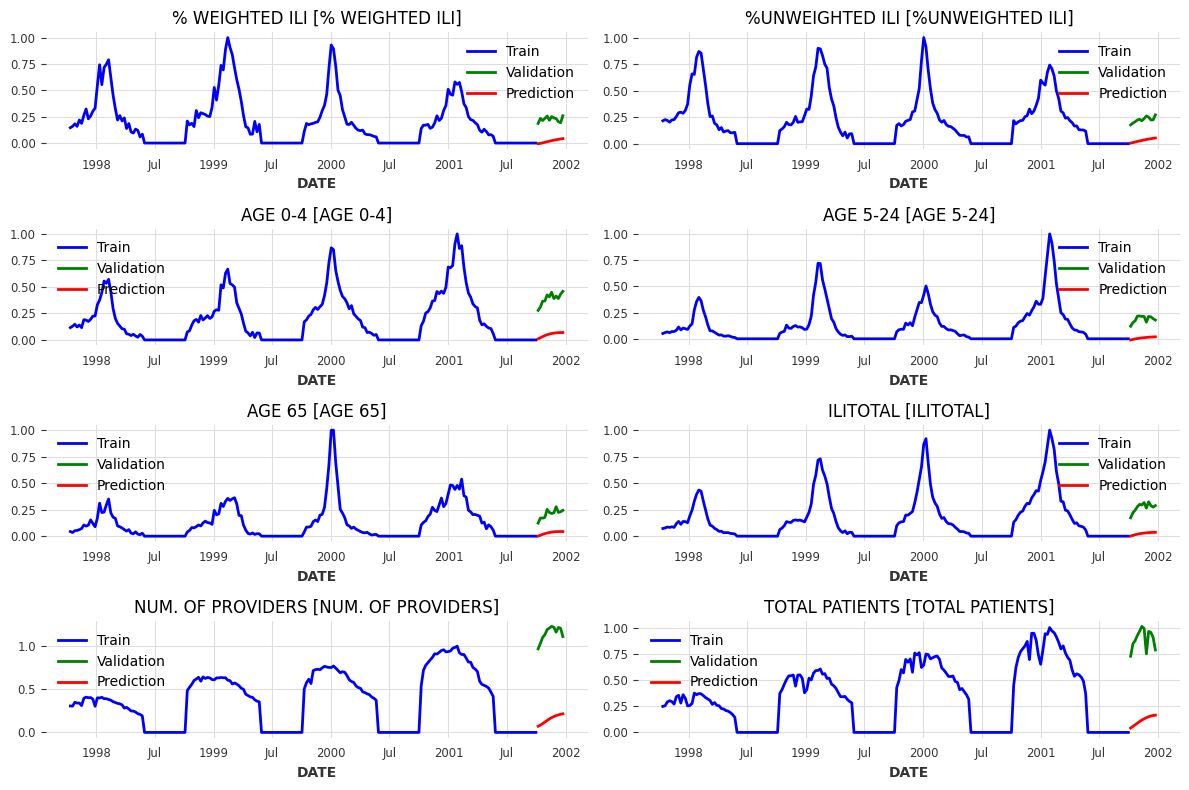

In [42]:
df_results = _display_prediction_evaluations(series_transformed, train_transformed, val_transformed, prediction, sharexy=False)


### ACTION: Calculate the Mean MASE Error for this model:

In [43]:
# Insert your code here:
df_results
print(df_results['MASE'].mean())
...

11.868913570568525


Ellipsis

### Q: Note down the Mean MASE Error:

Ans: 11.868913570568523

## 
## Task 2: Local Forecasting - Applied separately, using univariate Exponential Smoothing modeling:
- Now apply separately to each univariate component of the multivariate time series.

### ACTION: Fit the ExponentialSmoothing Model:

,MASE,MAPE,MAE,R2
% WEIGHTED ILI,4.772324,91.654565,0.207340,-80.467715
%UNWEIGHTED ILI,5.293622,86.631601,0.194999,-56.477072
AGE 0-4,9.977926,87.504930,0.340012,-42.897625
AGE 5-24,6.604554,96.484723,0.180560,-35.282118
AGE 65,6.466416,86.283540,0.180151,-18.808470
ILITOTAL,8.074759,91.520801,0.248031,-36.806534
NUM. OF PROVIDERS,33.994989,86.727117,0.994806,-157.245839
TOTAL PATIENTS,19.766719,87.060575,0.775935,-71.326560


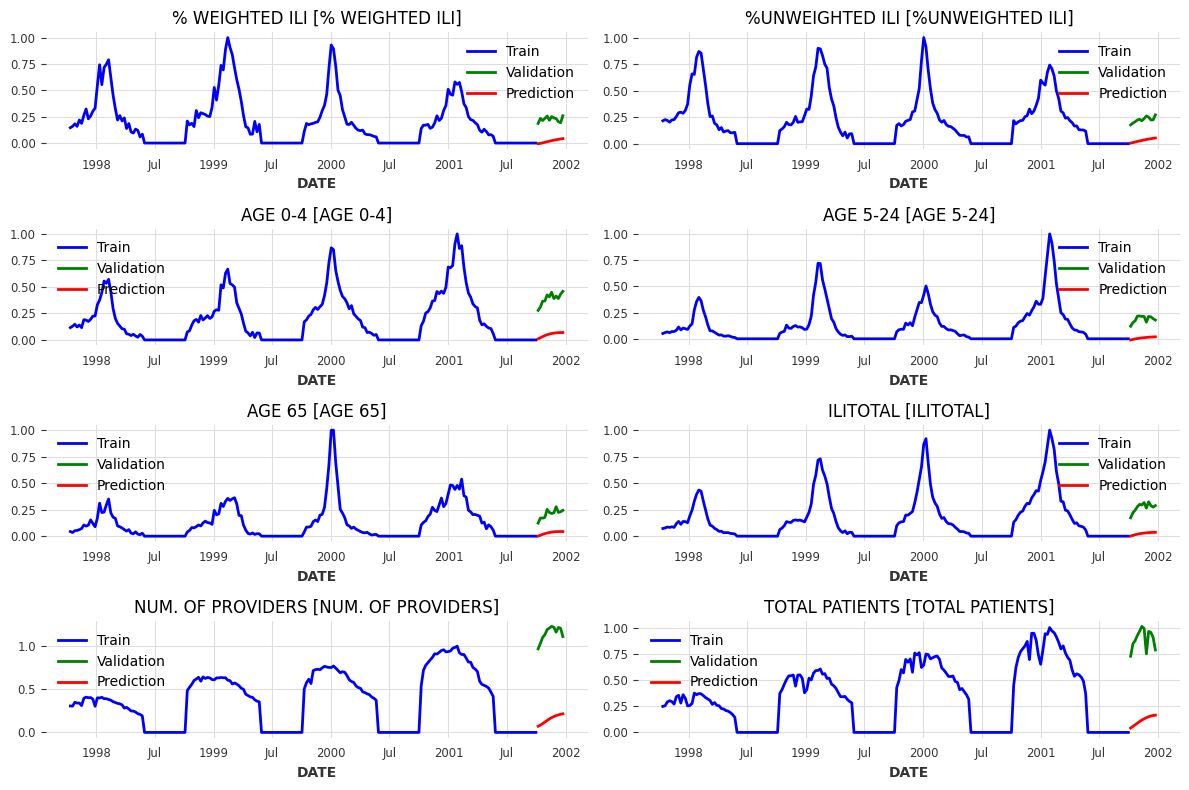

In [44]:
from darts.models import ExponentialSmoothing

predictions = {}
for component in train_transformed.components:
    model = ExponentialSmoothing()
    model.fit(train_transformed[component])
    predictions[component] = model.predict(n=len(val_transformed[component]))
    
df_results = _display_prediction_evaluations(series_transformed, train_transformed, val_transformed, prediction, sharexy=False)

### ACTION: Calculate the Mean MASE Error for this model:

In [45]:
# Insert your code here:
df_results
print(df_results['MASE'].mean())
...

11.868913570568525


Ellipsis

### Q: Note down the Mean MASE Error:

Ans: 11.868913570568523

```






```
<p style="text-align:center;">That's it! Congratulations! <br> 
    Now, call an LA to check your solution. Then, upload your code on MyCourses.</p>

```












```
# 
# 
# 
# 
# Homework on your Laptop for next week
## Set-up GPU Acceleration for Models: - Prerequisite Installation of CUDA Toolkit (e.g. v12.6) and PyTorch: (takes 1 hour!)
- Next week may require fine-training models, and GPU acceleration will speed up your training time (e.g. from 10 mins to 1 min).
- If you have time before end of class, you can try to check / set-up a desktop machine in the Lab (in preparation for next week).
## Step 1: - Check Torch & CUDA:
```python
import torch
torch.cuda.is_available()
> # True or False. If True, no need to install CUDA Toolkit or PyTorch:
```
## Step 2: - Check Available Versions for Compatibility:
- `Go to the PyTorch Install Guide Page:` - https://pytorch.org/get-started/locally/
    - Find compatible CUDA Toolkit version - 11.8, 12.4, 12.6 (for NVIDIA GPU)  or ROCm (for AMD GPU).
    - If you have MacOS, then "CPU" acceleration is the remaining option for the install command.
    - **Before installing check your CUDA Toolkit version**:
## Step 3: - Check Existing installation of CUDA Toolkit:
- Check whether your device has a NVIDIA GPU or an AMD GPU (or no GPU).
- Open your `"Add or Remove Programs"` in Windows (or search Apt-Get in Linux), and search for "CUDA Toolkit":
    - Check for a compatibile version already installed (e.g. 11.8, 12.4, 12.6) (or appropriate for ROCm).
    - `If already installed`, proceed to install PyTorch.
    - `If no compatibile version installed`, then install as follows: (~3GB or more).
        - https://developer.nvidia.com/cuda-toolkit-archive
            - e.g. https://developer.nvidia.com/cuda-12-6-0-download-archive
        - (latest verion and its install guide is here, but may not be compatible with PyTorch: https://developer.nvidia.com/cuda-downloads)
## Step 4: - Install Compatible PyTorch Version:
- Once a compatible CUDA Toolkit version is installed, install PyTorch
    - Now install PyTorch via the command you selected earlier. (~2.5 GB for Torch pip package)
        - e.g. `pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126`
- After the install is finished, Check `Step 1` again.
    




In [46]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126


Looking in indexes: https://download.pytorch.org/whl/cu126


In [47]:
import torch
torch.cuda.is_available()

True